In [1]:
TRAIN = '/kaggle/input/birds-dataset/Birds dataset.jpg'

We want to use image embeddings for EDA and classification, so let's add some code to get image embeddings using ResNeXt without fine-tuning.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 156MB/s]


Next let's load up all of our data, including image embeddings and thumbnails. We don't have a lot of data, so we can load it all.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from os.path import isdir
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGBA').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) ]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') if isdir(folder)}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
train_df['tag'] = train_df['tag'].apply(func=lambda x: x.replace('.jpg', '')) # make our classes human readable
print('done in {}'.format(arrow.now() - time_start))

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


encoded 49 rows of white parrot.jpg  in 0:00:09.331881
encoded 52 rows of gray parrot.jpg  in 0:00:08.444328
encoded 50 rows of macaw.jpg  in 0:00:08.506986
encoded 52 rows of amazon green parrot.jpg  in 0:00:09.264231
done in 0:00:35.604087


Our classes are roughly balanced. If they were exactly balanced there would be 25% in each class. 

In [4]:
train_df['tag'].value_counts(normalize=True).to_frame().T

tag,gray parrot,amazon green parrot,macaw,white parrot
proportion,0.256158,0.256158,0.246305,0.241379


Next let's use TSNE to add x/y coordinates based on our image vectors. We can use these to build a scatter plot that will show if our image vectors cluster according to class.

In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 203 samples in 0.002s...
[t-SNE] Computed neighbors for 203 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 203 / 203
[t-SNE] Mean sigma: 2.170378
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.605682
[t-SNE] KL divergence after 1000 iterations: 0.270387


Let's plot.

In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(n=min(7500, len(train_df)-1), random_state=2025))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: parrots', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? With the exception of three hard cases, all of our data clusters into clusters that are relatively tight and distinct. It should be easy to build an accurate model. Let's build a model and see what happens.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.25, random_state=2025, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test), zero_division=0.0))

model fit in 73 iterations
accuracy: 0.9804
f1: 0.9804
                     precision    recall  f1-score   support

amazon green parrot       0.93      1.00      0.96        13
        gray parrot       1.00      1.00      1.00        13
              macaw       1.00      0.92      0.96        13
       white parrot       1.00      1.00      1.00        12

           accuracy                           0.98        51
          macro avg       0.98      0.98      0.98        51
       weighted avg       0.98      0.98      0.98        51



We apparently got all three difficult cases into our test split. If we chose a different random seed we might get an f1 of 1.0 here. 

<Axes: xlabel='probability', ylabel='Count'>

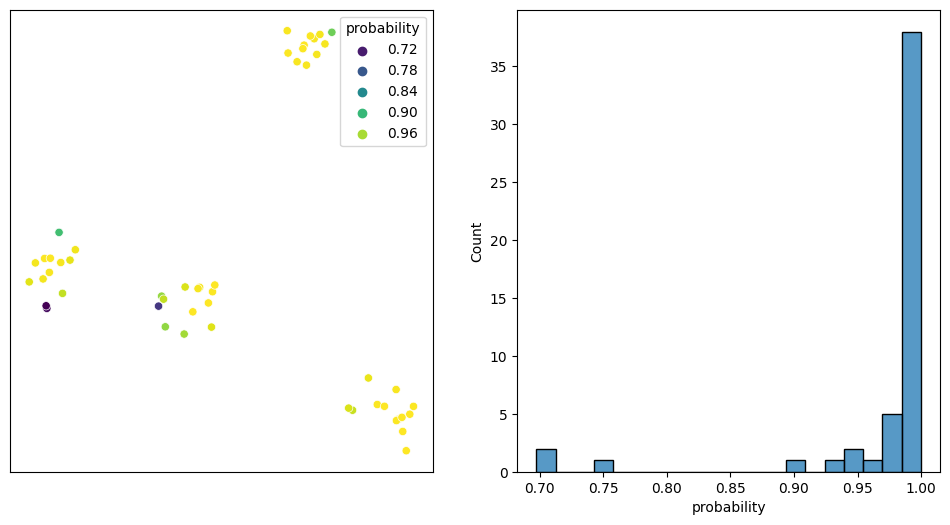

In [8]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis', )
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

For the most part our model probabilities are high; the model has lower confidence for three cases, which are not the difficult cases from the TSNE plot above.